In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

from imports.algorithm import gradient_tracking, gradient_descent
from imports.loss import QuadraticFunction, TargetLocalizationLoss
from imports.scenarios import create_network_of_agents, create_quadratic_problem, create_position_tracking_problem
from imports.plot import plot_scenario, plot_animation
from imports.utils import get_average_estimated_distance

from IPython.display import HTML

## Quadratic function

In [2]:
NUM_AGENTS = 10
VARS_DIM = 2
SEED = 42

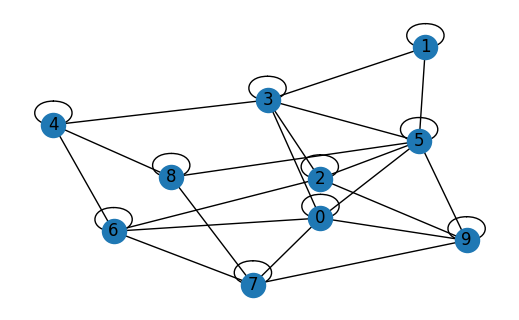

In [3]:
rng = np.random.default_rng(SEED)

G, A = create_network_of_agents(
    NUM_AGENTS,
    adjacency_form = "doubly-stochastic",
    graph_algorithm = "erdos_renyi",
    seed = int(rng.integers(0, 2**32))
)

local_quadratics, global_quadratic, optimal_z = create_quadratic_problem(
    A = A,
    vars_dim = VARS_DIM,
    seed = int(rng.integers(0, 2**32))
)
optimal_cost = global_quadratic(optimal_z)

z0 = rng.random(size=(NUM_AGENTS, VARS_DIM))


plt.figure(figsize=(5, 3))
nx.draw_kamada_kawai(G, with_labels=True)
plt.show()

Cost: -1.1664744812746466 | Optimal: -1.1665001028262578


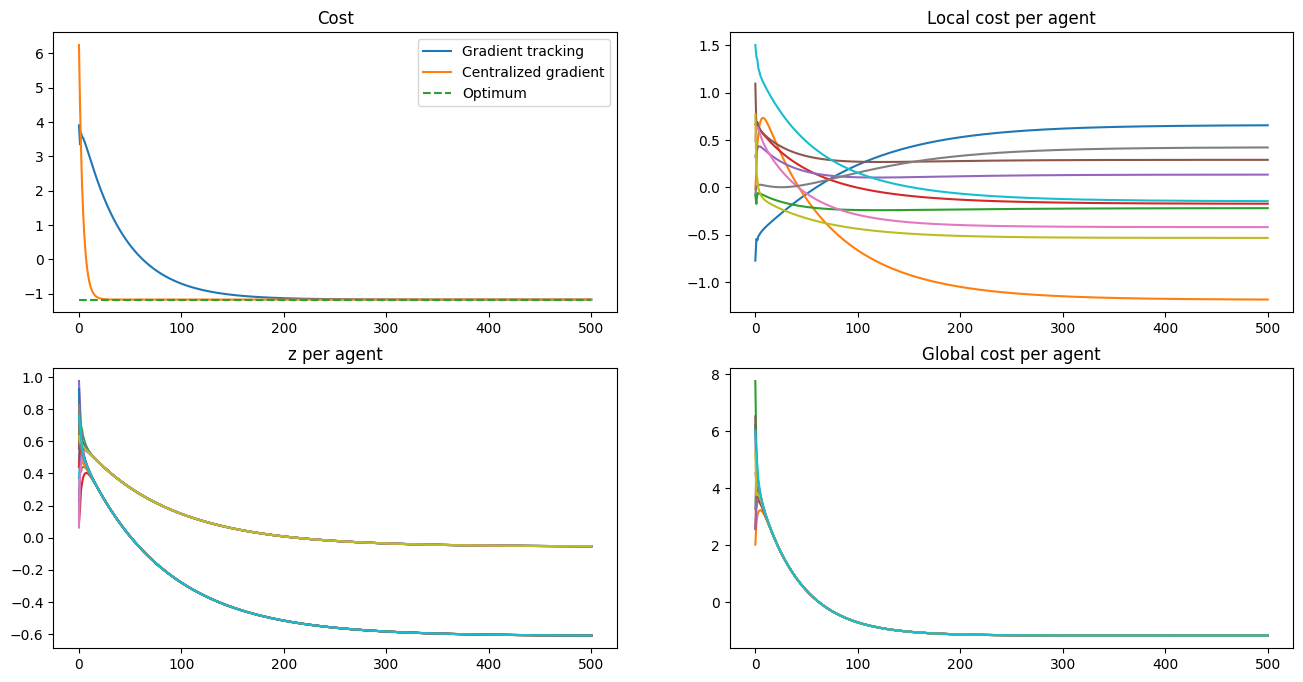

In [4]:
history_z = gradient_tracking(
    fn_list = local_quadratics,
    z0 = z0.copy(),
    A = A,
    num_iters = 500,
    alpha = 2e-2,
)

history_z_centralized = gradient_descent(
    fn_list = local_quadratics,
    z0 = z0[0].copy(),
    num_iters = 500,
    alpha = 2e-2,
)


print(f"Cost: {global_quadratic(history_z[-1].mean(axis=0))} | Optimal: {optimal_cost}")

plt.figure(figsize=(16, 8))

plt.subplot(2, 2, 1)
plt.title("Cost")
plt.plot([ sum(local_quadratics[i](z[i]) for i in range(NUM_AGENTS)) for z in history_z ], label="Gradient tracking")
plt.plot([ global_quadratic(z) for z in history_z_centralized ], label="Centralized gradient")
plt.plot([optimal_cost]*len(history_z), "--", label="Optimum")
plt.legend()

# plt.subplot(2, 2, 2)
# plt.title("grad cost")
# plt.plot([ np.linalg.norm(global_quadratic.grad(z.mean(axis=0))) for z in history_z ])

plt.subplot(2, 2, 2)
plt.title("Local cost per agent")
for i in range(NUM_AGENTS):
    plt.plot([ local_quadratics[i](z[i]) for z in history_z ], label=f"Cost agent {i}")

plt.subplot(2, 2, 3)
plt.title("z per agent")
for i in range(NUM_AGENTS):
    plt.plot([ z[i] for z in history_z ], label=f"z agent {i}")

plt.subplot(2, 2, 4)
plt.title("Global cost per agent")
for i in range(NUM_AGENTS):
    plt.plot([ global_quadratic(z[i]) for z in history_z ], label=f"Cost agent {i}")

plt.show()

## Position tracking

In [5]:
NUM_ROBOTS = 10
NUM_TARGETS = 2
VARS_DIM = 2

SEED = 42

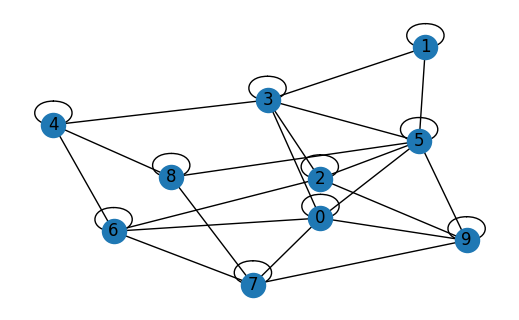

In [6]:
rng = np.random.default_rng(SEED)

G, A = create_network_of_agents(
    NUM_ROBOTS,
    adjacency_form = "doubly-stochastic",
    graph_algorithm = "erdos_renyi",
    seed = int(rng.integers(0, 2**32))
)

local_losses, global_loss, (robots_pos, targets_pos_real, est_targets_dists) = create_position_tracking_problem(
    A = A,
    num_targets = NUM_TARGETS,
    vars_dim = VARS_DIM,
    noise_type = "gaussian",
    gaussian_mean = 0.0,
    gaussian_std = 1.0,
    noise_ratio = 0.01,
    seed = int(rng.integers(0, 2**32))
)

z0 = rng.random(size=(NUM_ROBOTS, NUM_TARGETS*VARS_DIM))


plt.figure(figsize=(5, 3))
nx.draw_kamada_kawai(G, with_labels=True)
plt.show()

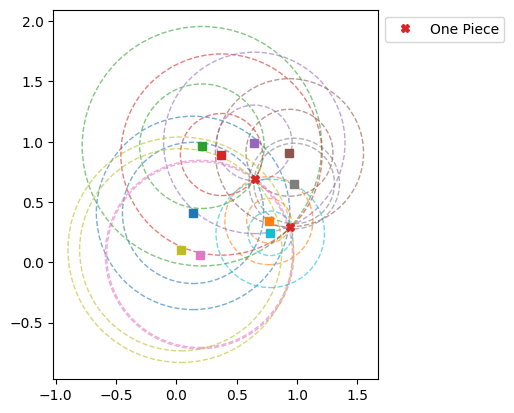

In [7]:
%matplotlib inline
plot_scenario(robots_pos, targets_pos_real, est_targets_dists)
plt.show()

In [8]:
history_z = gradient_tracking(
    fn_list = local_losses,
    z0 = z0.copy(),
    A = A,
    num_iters = 1000,
    alpha = 1e-2,
)
history_z = history_z.reshape(-1, NUM_ROBOTS, NUM_TARGETS, VARS_DIM)

history_z_centralized = gradient_descent(
    fn_list = local_losses,
    z0 = z0[0].copy(),
    num_iters = 1000,
    alpha = 1e-2,
)
history_z_centralized = history_z_centralized.reshape(-1, NUM_TARGETS, VARS_DIM)

In [9]:
%matplotlib inline

print(f"Loss (gradient tracking):    {sum( local_losses[i](history_z[-1, i].flatten()) for i in range(NUM_ROBOTS) )}")
print(f"Average estimated distance:  {get_average_estimated_distance(history_z[-1], targets_pos_real)}")
print()
print(f"Loss (centralized gradient): {sum( local_losses[i](history_z_centralized[-1].flatten()) for i in range(NUM_ROBOTS) )}")


plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.title("Loss")
plt.plot([ sum(local_losses[i](z[i].flatten()) for i in range(NUM_ROBOTS)) for z in history_z ], label="Gradient tracking")
plt.plot([ sum(local_losses[i](z.flatten()) for i in range(NUM_ROBOTS)) for z in history_z_centralized ], label="Centralized gradient")
plt.legend()
plt.semilogy()

plt.subplot(1, 2, 2)
plt.title("Norm grad")
plt.plot([ sum(np.linalg.norm(local_losses[i].grad(z[i].flatten())) for i in range(NUM_ROBOTS)) for z in history_z ], label="Gradient tracking")
plt.plot([ sum(np.linalg.norm(local_losses[i].grad(z.flatten())) for i in range(NUM_ROBOTS)) for z in history_z_centralized ], label="Centralized gradient")
plt.legend()
plt.semilogy()

plt.show()

Loss (gradient tracking):    0.0020108845981741895
Average estimated distance:  0.003393552337121657

Loss (centralized gradient): 0.0020106233928470947


In [10]:
%matplotlib notebook
anim = plot_animation(robots_pos, targets_pos_real, history_z, ff_threshold=30)
HTML(anim.to_jshtml())

<IPython.core.display.Javascript object>